# Notebook 04 — Advanced Analyses (Time-Agnostic)

**Purpose**: Clustering, attribution (cross-sectional), elasticity, fraud detection (aggregate), scenario-based revenue projection (replacement for time-series forecasting), and what-if simulations — all without using dates.

**Key Analyses**:
- K-means clustering (hits vs evergreen vs niche)
- Cross-sectional attribution analysis
- Elasticity modeling (revenue vs streams)
- Fraud detection using IsolationForest
- Scenario-based revenue projections
- What-if simulations for conversion strategies

In [1]:
# Cell 1 — Imports & Load Cleaned Data
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Setup paths
DATA_DIR = Path('../data')
CLEANED_DATA = Path('../outputs/cleaned/df_all.parquet')
OUTPUT_DIR = Path('../outputs/advanced')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load cleaned data if available, otherwise load and clean raw
if CLEANED_DATA.exists():
    print("Loading cleaned data from Notebook 02...")
    df = pd.read_parquet(CLEANED_DATA)
    print(f"Loaded {len(df):,} rows")
else:
    print("Cleaned data not found. Loading raw CSVs...")
    airtel = pd.read_csv(DATA_DIR/'airtel-report.csv', encoding='utf-8')
    jio = pd.read_csv(DATA_DIR/'jiosaavn-report.csv', encoding='utf-8')
    wynk = pd.read_csv(DATA_DIR/'wynk-report.csv', encoding='utf-8')
    
    def normalize_columns(df):
        df = df.copy()
        df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
        return df
    
    airtel = normalize_columns(airtel)
    jio = normalize_columns(jio)
    wynk = normalize_columns(wynk)
    
    # Map to canonical schema
    def map_schema(df, src):
        df = df.copy()
        mapping = {
            'track': ['song_name','song','track','title'],
            'artist': ['artist','artist_name','artistname'],
            'album': ['album','album_name'],
            'revenue': ['rev','revenue','income','royality','royalty'],
            'stream_count': ['stream_count','streams','stream','play_count'],
            'store_name': ['store','store_name','platform','source']
        }
        col_map = {}
        for tgt, candidates in mapping.items():
            for c in candidates:
                if c in df.columns:
                    col_map[c] = tgt
                    break
        df = df.rename(columns=col_map)
        df['source'] = src
        return df
    
    airtel = map_schema(airtel, 'airtel')
    jio = map_schema(jio, 'jiosaavn')
    wynk = map_schema(wynk, 'wynk')
    
    df = pd.concat([airtel, jio, wynk], ignore_index=True, sort=False)
    
    # Clean numeric columns
    df['revenue'] = pd.to_numeric(df.get('revenue', 0), errors='coerce').fillna(0.0)
    df['stream_count'] = pd.to_numeric(df.get('stream_count', 0), errors='coerce').fillna(0)
    df['artist'] = df.get('artist','').astype(str).str.strip()
    df['track'] = df.get('track', df.get('song_name','')).astype(str).str.strip()
    df['album'] = df.get('album','').astype(str).str.strip()
    
    print(f"Loaded and cleaned {len(df):,} rows")

df.head()

Loading cleaned data from Notebook 02...
Loaded 8,882 rows


,source,activity_period,year_month,store_name,country,artist,album,track,revenue,stream_count,unit_type,project_code
0,jiosaavn,NaT,NaN,JioSaavn,India,Jojo Mrinal Mukherjee Prem Kumar,Tara Maa Ki Mahima Aapar,Tara Maiya Tere Darbar,0.675,9.0,NaN,INT441651504
1,jiosaavn,NaT,NaN,JioSaavn,India,Sanchita Shaan Swarna,Hiya Deba Kaak,Lovely Lovely Night,0.375,5.0,NaN,INT441629102
2,jiosaavn,NaT,NaN,JioSaavn,India,Indradeep Dasgupta,Kanamachi,Mon Bawra,36.150,482.0,NaN,INT441632205
3,jiosaavn,NaT,NaN,JioSaavn,India,Raja Narayan Deb,Monchuri,Bolo Bolo Bolo Shobe,0.450,6.0,NaN,INT441636701
4,jiosaavn,NaT,NaN,JioSaavn,India,Jojo Mrinal Mukherjee Prem Kumar,Tara Maa Ki Mahima Aapar,Natraj Nache Re,0.675,9.0,NaN,INT441651502


In [2]:
# Cell 2 — Basic KPIs (Cross-Sectional)
total_revenue = df['revenue'].sum()
total_streams = df['stream_count'].sum()
unique_artists = df['artist'].nunique()
unique_tracks = df['track'].nunique()
top_store = df.groupby('source')['revenue'].sum().sort_values(ascending=False).head(1)

kpis = {
    'total_revenue': total_revenue,
    'total_streams': int(total_streams),
    'unique_artists': int(unique_artists),
    'unique_tracks': int(unique_tracks),
    'top_store': top_store.index[0] if not top_store.empty else None,
    'top_store_revenue': float(top_store.iloc[0]) if not top_store.empty else 0.0
}

print("="*60)
print("CROSS-SECTIONAL KPIs")
print("="*60)
for k, v in kpis.items():
    if isinstance(v, (int, float)):
        print(f"{k:30s}: {v:,.2f}" if isinstance(v, float) else f"{k:30s}: {v:,}")
    else:
        print(f"{k:30s}: {v}")
print("="*60)

kpis

CROSS-SECTIONAL KPIs
total_revenue                 : 29,700.78
total_streams                 : 497,421
unique_artists                : 2,459
unique_tracks                 : 6,672
top_store                     : wynk
top_store_revenue             : 22,760.58


{'total_revenue': np.float64(29700.77935574),
 'total_streams': 497421,
 'unique_artists': 2459,
 'unique_tracks': 6672,
 'top_store': 'wynk',
 'top_store_revenue': 22760.57935574}

In [3]:
# Cell 3 — Top Artists, Albums, Tracks Tables
print("Generating top performers tables...\n")

# Top Artists
top_artists = df.groupby('artist', as_index=False).agg(
    total_revenue=('revenue','sum'),
    total_streams=('stream_count','sum')
).sort_values('total_revenue', ascending=False)
top_artists['avg_revenue_per_stream'] = top_artists['total_revenue'] / top_artists['total_streams'].replace(0, np.nan)
top_artists = top_artists.head(20)

# Top Albums
top_albums = df.groupby('album', as_index=False).agg(
    total_revenue=('revenue','sum'),
    total_tracks=('track','nunique')
).sort_values('total_revenue', ascending=False).head(20)

# Top Tracks
top_tracks = df.groupby('track', as_index=False).agg(
    artist=('artist', lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0] if len(s) > 0 else ''),
    total_revenue=('revenue','sum'),
    total_streams=('stream_count','sum')
).sort_values('total_revenue', ascending=False).head(50)
top_tracks['revenue_per_stream'] = top_tracks['total_revenue'] / top_tracks['total_streams'].replace(0, np.nan)

# Export snapshots
top_artists.to_csv(OUTPUT_DIR/'top_artists.csv', index=False)
top_albums.to_csv(OUTPUT_DIR/'top_albums.csv', index=False)
top_tracks.to_csv(OUTPUT_DIR/'top_tracks.csv', index=False)

print(f"✅ Exported top_artists.csv ({len(top_artists)} rows)")
print(f"✅ Exported top_albums.csv ({len(top_albums)} rows)")
print(f"✅ Exported top_tracks.csv ({len(top_tracks)} rows)")
print("\nTop 10 Artists by Revenue:")
display(top_artists.head(10))

Generating top performers tables...

✅ Exported top_artists.csv (20 rows)
✅ Exported top_albums.csv (20 rows)
✅ Exported top_tracks.csv (50 rows)

Top 10 Artists by Revenue:


,artist,total_revenue,total_streams,avg_revenue_per_stream
708,F A Sumon,9318.861616,165875.0,0.056180
944,Kaushik Chakraborty,998.393974,17704.0,0.056394
235,Arijit Singh,755.228074,13443.0,0.056180
1701,S.P. Venkatesh,677.850000,9038.0,0.075000
1464,Pratik Sen,616.961729,8722.0,0.070736
1990,Shreya Ghoshal,570.957592,10163.0,0.056180
790,Iman Chakraborty,496.481979,8836.0,0.056189
1689,Rupam Islam,479.578736,6762.0,0.070923
190,Anupam Roy,475.938564,8404.0,0.056632
1526,Rabindranath Tagore,422.400000,5632.0,0.075000


In [4]:
# Cell 4 — Cross-Sectional Anomaly Detection (Outliers without Time)
print("Running anomaly detection based on revenue outliers...\n")

# Calculate revenue per stream
df['revenue_per_stream'] = df.apply(
    lambda r: (r['revenue'] / r['stream_count']) if r['stream_count'] > 0 else 0, 
    axis=1
)

# Define simple outlier rules (top 0.5% for each metric)
rev_outliers = df[df['revenue'] > df['revenue'].quantile(0.995)]
rps_outliers = df[df['revenue_per_stream'] > df['revenue_per_stream'].quantile(0.995)]
streams_outliers = df[df['stream_count'] > df['stream_count'].quantile(0.995)]

# Mark outliers
df['is_rev_outlier'] = df.index.isin(rev_outliers.index)
df['is_rps_outlier'] = df.index.isin(rps_outliers.index)
df['is_streams_outlier'] = df.index.isin(streams_outliers.index)

# Export anomalies
anomalies = df[df[['is_rev_outlier','is_rps_outlier','is_streams_outlier']].any(axis=1)]
anomalies.to_csv(OUTPUT_DIR/'anomalies_cross_section.csv', index=False)

print(f"Revenue outliers (top 0.5%):        {len(rev_outliers):,} rows")
print(f"Revenue/stream outliers (top 0.5%): {len(rps_outliers):,} rows")
print(f"Stream count outliers (top 0.5%):   {len(streams_outliers):,} rows")
print(f"\nTotal unique anomalies flagged:     {len(anomalies):,} rows")
print(f"✅ Exported to anomalies_cross_section.csv")

print("\nSample anomalies:")
display(anomalies[['source','artist','track','revenue','stream_count','revenue_per_stream',
                   'is_rev_outlier','is_rps_outlier','is_streams_outlier']].head(10))

Running anomaly detection based on revenue outliers...

Revenue outliers (top 0.5%):        45 rows
Revenue/stream outliers (top 0.5%): 0 rows
Stream count outliers (top 0.5%):   45 rows

Total unique anomalies flagged:     47 rows
✅ Exported to anomalies_cross_section.csv

Sample anomalies:


,source,artist,track,revenue,stream_count,revenue_per_stream,is_rev_outlier,is_rps_outlier,is_streams_outlier
348,jiosaavn,Indradeep Dasgupta,Jani Dekha Howbe Male,94.050,1254.0,0.075,True,False,True
806,jiosaavn,Rupam Islam,Daniken,352.575,4701.0,0.075,True,False,True
815,jiosaavn,Rabindranath Tagore,Majhe Majhe Tobo Dekha Pai,88.200,1176.0,0.075,True,False,True
914,jiosaavn,Pratik Sen,Prithibita Naki Choto Hotey Hotey,505.125,6735.0,0.075,True,False,True
978,jiosaavn,Indradeep Dasgupta,Jani Dekha Howbe Female,180.000,2400.0,0.075,True,False,True
1062,jiosaavn,S.P. Venkatesh,Chena Chena A Poth,76.050,1014.0,0.075,True,False,False
1358,jiosaavn,S.P. Venkatesh,Meghla Dine Meghla Mon,270.600,3608.0,0.075,True,False,True
1598,jiosaavn,Sreeradha Bandyopadhyay,Jokhon Porbe Na Mor,138.750,1850.0,0.075,True,False,True
1753,jiosaavn,Banasri Ghoshal,Dil Jane Na,396.525,5287.0,0.075,True,False,True
1975,jiosaavn,S.P. Venkatesh,Amar Prothom Prem,83.475,1113.0,0.075,True,False,False


In [5]:
# Cell 5 — Clustering Tracks/Artists (K-Means)
print("Running K-means clustering on top tracks...\n")

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Prepare features for clustering
features = top_tracks[['total_revenue','total_streams','revenue_per_stream']].fillna(0)
scaler = StandardScaler()
X = scaler.fit_transform(features)

# Choose 3 clusters: Hit, Evergreen, Niche
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)
top_tracks['cluster'] = labels

# Analyze clusters
cluster_summary = top_tracks.groupby('cluster').agg(
    n_tracks=('track','count'),
    mean_revenue=('total_revenue','mean'),
    mean_streams=('total_streams','mean'),
    mean_rps=('revenue_per_stream','mean')
).reset_index()

# Label clusters based on characteristics
cluster_names = {}
for idx, row in cluster_summary.iterrows():
    if row['mean_rps'] > cluster_summary['mean_rps'].median():
        if row['mean_streams'] > cluster_summary['mean_streams'].median():
            cluster_names[row['cluster']] = 'Hit (High Value + High Volume)'
        else:
            cluster_names[row['cluster']] = 'Niche (High Value + Low Volume)'
    else:
        cluster_names[row['cluster']] = 'Evergreen (Moderate Value)'

top_tracks['cluster_name'] = top_tracks['cluster'].map(cluster_names)
cluster_summary['cluster_name'] = cluster_summary['cluster'].map(cluster_names)

# Export
top_tracks.to_csv(OUTPUT_DIR/'top_tracks_with_clusters.csv', index=False)
print(f"✅ Exported top_tracks_with_clusters.csv\n")

print("CLUSTER SUMMARY")
print("="*60)
display(cluster_summary)

print("\nSample tracks from each cluster:")
for cluster_id in sorted(top_tracks['cluster'].unique()):
    print(f"\n{cluster_names[cluster_id]}:")
    display(top_tracks[top_tracks['cluster']==cluster_id][['track','artist','total_revenue','total_streams','revenue_per_stream']].head(3))

Running K-means clustering on top tracks...

✅ Exported top_tracks_with_clusters.csv

CLUSTER SUMMARY
✅ Exported top_tracks_with_clusters.csv

CLUSTER SUMMARY


,cluster,n_tracks,mean_revenue,mean_streams,mean_rps,cluster_name
0,0,15,196.867946,2762.266667,0.071382,Niche (High Value + Low Volume)
1,1,1,7509.752457,133673.000000,0.056180,Evergreen (Moderate Value)
2,2,34,227.001754,3976.235294,0.057165,Evergreen (Moderate Value)



Sample tracks from each cluster:

Niche (High Value + Low Volume):


,track,artist,total_revenue,total_streams,revenue_per_stream
5213,Prithibita Naki Choto Hotey Hotey,Pratik Sen,616.024369,8709.0,0.070734
1956,Daniken,Rupam Islam,403.698823,5611.0,0.071948
2108,Dil Jane Na,Banasri Ghoshal,396.749720,5291.0,0.074986



Evergreen (Moderate Value):


,track,artist,total_revenue,total_streams,revenue_per_stream
3051,Jaan Re Tui,F A Sumon,7509.752457,133673.0,0.05618



Evergreen (Moderate Value):


,track,artist,total_revenue,total_streams,revenue_per_stream
3876,Krishna Bhajan,Kaushik Chakraborty,992.286932,17603.0,0.05637
2954,Hoyto Tomari Jonno,Arijit Singh,736.744845,13114.0,0.05618
3141,Janere Khuda Jane,F A Sumon,673.879398,11995.0,0.05618


In [6]:
# Cell 6 — Attribution (Cross-Sectional / Platform Comparison)
print("Running cross-sectional attribution analysis...\n")

# Check for promotion or feature flags
promo_cols = [c for c in df.columns if 'promo' in c.lower() or 'feature' in c.lower() or 'promotion' in c.lower()]
promo_col = promo_cols[0] if promo_cols else None

if promo_col:
    print(f"Found promotion column: {promo_col}")
    grp = df.groupby(promo_col).agg(
        total_revenue=('revenue','sum'), 
        avg_revenue=('revenue','mean'), 
        n=('revenue','count')
    ).reset_index()
else:
    # Use platform/source as attribution dimension
    print("No promotion column found. Using 'source' platform for attribution analysis.")
    promo_col = 'source'
    grp = df.groupby(promo_col).agg(
        total_revenue=('revenue','sum'), 
        avg_revenue=('revenue','mean'),
        median_revenue=('revenue','median'),
        n=('revenue','count')
    ).reset_index()

grp['revenue_share_%'] = (grp['total_revenue'] / grp['total_revenue'].sum()) * 100
grp = grp.sort_values('total_revenue', ascending=False)

grp.to_csv(OUTPUT_DIR/'attribution_cross_section.csv', index=False)
print(f"\n✅ Exported attribution_cross_section.csv\n")

print("ATTRIBUTION ANALYSIS BY PLATFORM")
print("="*60)
display(grp)

print("\n💡 INSIGHT: Compare avg_revenue across platforms to identify which drives higher value per transaction.")

Running cross-sectional attribution analysis...

No promotion column found. Using 'source' platform for attribution analysis.

✅ Exported attribution_cross_section.csv

ATTRIBUTION ANALYSIS BY PLATFORM


,source,total_revenue,avg_revenue,median_revenue,n,revenue_share_%
1,wynk,22760.579356,3.661612,0.16854,6216,76.632936
0,jiosaavn,6940.200000,2.603226,0.22500,2666,23.367064



💡 INSIGHT: Compare avg_revenue across platforms to identify which drives higher value per transaction.


In [7]:
# Cell 7 — Elasticity (Cross-Sectional Proxy)
print("Running elasticity analysis (log-log regression)...\n")

import statsmodels.formula.api as smf

# Check for price column
price_col = None
for c in df.columns:
    if 'price' in c.lower() or 'tariff' in c.lower() or 'amount' in c.lower():
        price_col = c
        break

df_el = df.copy()

if price_col:
    print(f"Found price column: {price_col}")
    df_el = df_el[df_el[price_col] > 0]
    df_el['log_rev'] = np.log(df_el['revenue'] + 1)
    df_el['log_price'] = np.log(df_el[price_col] + 1)
    model = smf.ols('log_rev ~ log_price', data=df_el).fit()
    elasticity = model.params.get('log_price', np.nan)
    formula = 'log(revenue) ~ log(price)'
else:
    # Proxy regression: revenue_per_stream vs stream_count
    print("No price column found. Using proxy: log(revenue_per_stream) ~ log(stream_count)")
    df_el = df_el[(df_el['stream_count'] > 0) & (df_el['revenue_per_stream'] > 0)]
    df_el['log_revps'] = np.log(df_el['revenue_per_stream'])
    df_el['log_streams'] = np.log(df_el['stream_count'])
    model = smf.ols('log_revps ~ log_streams', data=df_el).fit()
    elasticity = model.params.get('log_streams', np.nan)
    formula = 'log(revenue_per_stream) ~ log(stream_count)'

elasticity_summary = model.summary()

# Save summary
with open(OUTPUT_DIR/'elasticity_summary.txt','w') as f:
    f.write(str(elasticity_summary))

print(f"\n✅ Exported elasticity_summary.txt\n")
print("="*60)
print(f"ELASTICITY ANALYSIS")
print("="*60)
print(f"Formula: {formula}")
print(f"Elasticity coefficient: {elasticity:.4f}")
print(f"R-squared: {model.rsquared:.4f}")
print(f"P-value: {model.f_pvalue:.6f}")
print(f"Observations: {int(model.nobs):,}")
print("="*60)

if abs(elasticity) > 1:
    print("\n💡 INSIGHT: Elastic relationship (|coefficient| > 1) - demand is sensitive to changes.")
else:
    print("\n💡 INSIGHT: Inelastic relationship (|coefficient| < 1) - demand is less sensitive to changes.")

print("\nFull regression summary:")
print(elasticity_summary)

Running elasticity analysis (log-log regression)...

No price column found. Using proxy: log(revenue_per_stream) ~ log(stream_count)

✅ Exported elasticity_summary.txt

ELASTICITY ANALYSIS
Formula: log(revenue_per_stream) ~ log(stream_count)
Elasticity coefficient: 0.0014
R-squared: 0.0003
P-value: 0.095203
Observations: 8,873

💡 INSIGHT: Inelastic relationship (|coefficient| < 1) - demand is less sensitive to changes.

Full regression summary:
                            OLS Regression Results                            
Dep. Variable:              log_revps   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.785
Date:                Fri, 21 Nov 2025   Prob (F-statistic):             0.0952
Time:                        19:50:27   Log-Likelihood:                 5352.4
No. Observations:                8873   AIC:                        -1.070e+0

In [8]:
# Cell 8 — Fraud Detection (Aggregate Patterns)
print("Running fraud detection using IsolationForest...\n")

from sklearn.ensemble import IsolationForest

# Prepare features
af = df[['stream_count','revenue','revenue_per_stream']].fillna(0)

# Train IsolationForest (contamination = expected fraud rate)
clf = IsolationForest(contamination=0.01, random_state=42)
df['fraud_score'] = clf.fit_predict(af)
df['is_fraud'] = df['fraud_score'] == -1

# Export flagged records
fraud_records = df[df['is_fraud']]
fraud_records.to_csv(OUTPUT_DIR/'fraud_flags.csv', index=False)

print(f"Total records analyzed:     {len(df):,}")
print(f"Fraud flags detected:       {fraud_records['is_fraud'].sum():,} ({(fraud_records['is_fraud'].sum()/len(df)*100):.2f}%)")
print(f"\n✅ Exported fraud_flags.csv\n")

print("Sample fraud-flagged records:")
display(fraud_records[['source','artist','track','revenue','stream_count','revenue_per_stream']].head(10))

print("\n💡 INSIGHT: Review flagged records for unusual patterns (e.g., very high revenue with low streams, or vice versa).")

Running fraud detection using IsolationForest...


Total records analyzed:     8,882
Fraud flags detected:       89 (1.00%)

✅ Exported fraud_flags.csv

Sample fraud-flagged records:


,source,artist,track,revenue,stream_count,revenue_per_stream
2,jiosaavn,Indradeep Dasgupta,Mon Bawra,36.150,482.0,0.075
41,jiosaavn,Paramita Danda,Sei Valo Sei Valo,69.675,929.0,0.075
274,jiosaavn,Somparna Burai,Jol Phoring,42.150,562.0,0.075
294,jiosaavn,Debanjali Chatterjee Hemlata Chakraborty Swy...,Anondoloke,40.800,544.0,0.075
322,jiosaavn,Dr. Shantanu Bhowmik,Amar Hriday,40.875,545.0,0.075
348,jiosaavn,Indradeep Dasgupta,Jani Dekha Howbe Male,94.050,1254.0,0.075
362,jiosaavn,S.P. Venkatesh,Sure Sure Sat Sure,61.650,822.0,0.075
401,jiosaavn,Habib Wahid,Bhalobasa Dao Bhalobasa Naw,73.575,981.0,0.075
449,jiosaavn,Sreeyanka Banerjee,Tumi Ami Porshi Nodi,49.875,665.0,0.075
524,jiosaavn,Dr. Shantanu Bhowmik,Amar Mon Kemon Kore,36.750,490.0,0.075



💡 INSIGHT: Review flagged records for unusual patterns (e.g., very high revenue with low streams, or vice versa).


Generating scenario-based revenue projections...

Current Revenue Baseline: ₹29,700.78

✅ Exported scenario_projections_3periods.csv

SCENARIO PROJECTIONS (Next 3 Periods)


,scenario,period,projected_revenue,cumulative_growth_%
0,Conservative (1% monthly growth),1,29997.787149,1.0000
1,Conservative (1% monthly growth),2,30297.765021,2.0100
2,Conservative (1% monthly growth),3,30600.742671,3.0301
3,Base Case (2% monthly growth),1,30294.794943,2.0000
4,Base Case (2% monthly growth),2,30900.690842,4.0400
5,Base Case (2% monthly growth),3,31518.704659,6.1208
6,Optimistic (3% monthly growth),1,30591.802736,3.0000
7,Optimistic (3% monthly growth),2,31509.556819,6.0900
8,Optimistic (3% monthly growth),3,32454.843523,9.2727
9,High Growth (5% monthly growth),1,31185.818324,5.0000


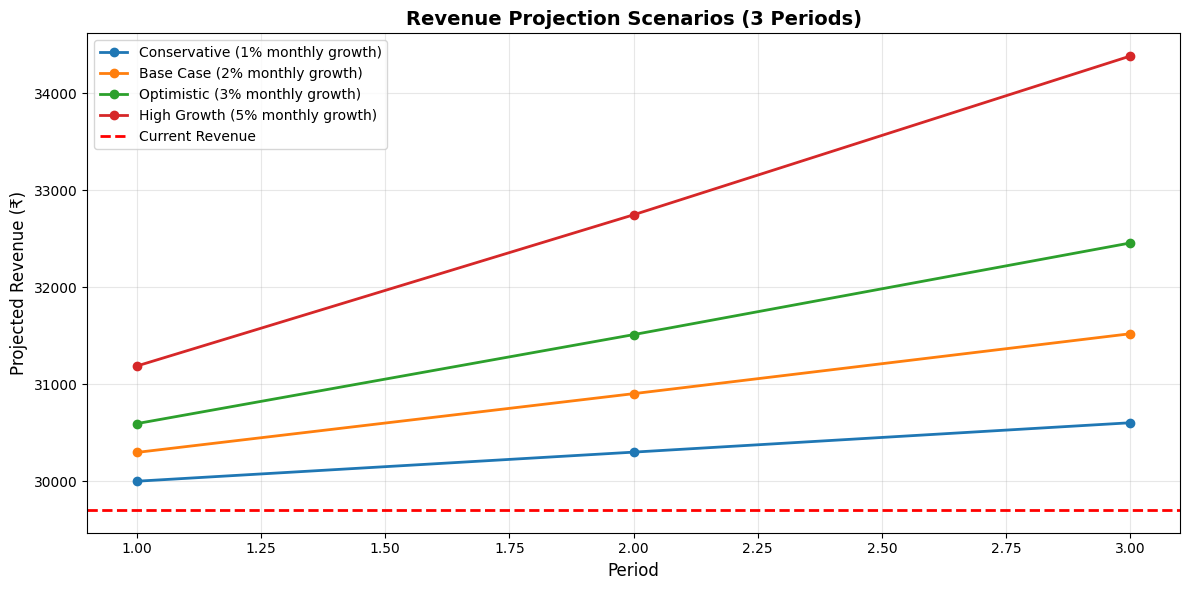


✅ Saved scenario_projections.png


In [9]:
# Cell 9 — Scenario-Based Revenue Projection (Replacement for Time-Series Forecast)
print("Generating scenario-based revenue projections...\n")

total_current_revenue = total_revenue

scenarios = {
    'Conservative (1% monthly growth)': 0.01,
    'Base Case (2% monthly growth)': 0.02,
    'Optimistic (3% monthly growth)': 0.03,
    'High Growth (5% monthly growth)': 0.05
}

projections = []
for name, monthly_rate in scenarios.items():
    rev = total_current_revenue
    for period in range(1, 4):  # Project 3 periods
        rev = rev * (1 + monthly_rate)
        projections.append({
            'scenario': name, 
            'period': period, 
            'projected_revenue': rev,
            'cumulative_growth_%': ((rev / total_current_revenue - 1) * 100)
        })

proj_df = pd.DataFrame(projections)
proj_df.to_csv(OUTPUT_DIR/'scenario_projections_3periods.csv', index=False)

print(f"Current Revenue Baseline: ₹{total_current_revenue:,.2f}\n")
print("✅ Exported scenario_projections_3periods.csv\n")

print("SCENARIO PROJECTIONS (Next 3 Periods)")
print("="*80)
display(proj_df)

# Visualization
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 6))

for scenario_name in proj_df['scenario'].unique():
    data = proj_df[proj_df['scenario'] == scenario_name]
    ax.plot(data['period'], data['projected_revenue'], marker='o', label=scenario_name, linewidth=2)

ax.axhline(y=total_current_revenue, color='red', linestyle='--', label='Current Revenue', linewidth=2)
ax.set_xlabel('Period', fontsize=12)
ax.set_ylabel('Projected Revenue (₹)', fontsize=12)
ax.set_title('Revenue Projection Scenarios (3 Periods)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR/'scenario_projections.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Saved scenario_projections.png")

Running what-if analysis: Ad-user to subscriber conversion...

WHAT-IF ANALYSIS: AD-USER TO SUBSCRIBER CONVERSION
Assumptions:
  - Estimated unique ad-users:          1,000,000
  - Avg subscriber monthly revenue:     ₹50.00
  - Current total monthly revenue:      ₹29,700.78

✅ Exported whatif_conversion_results.csv



,conversion_rate_%,new_subscribers,monthly_incremental_revenue,annual_incremental_revenue,monthly_revenue_increase_%
0,0.5,5000,250000.0,3000000.0,841.728754
1,1.0,10000,500000.0,6000000.0,1683.457508
2,2.0,20000,1000000.0,12000000.0,3366.915016
3,5.0,50000,2500000.0,30000000.0,8417.287540


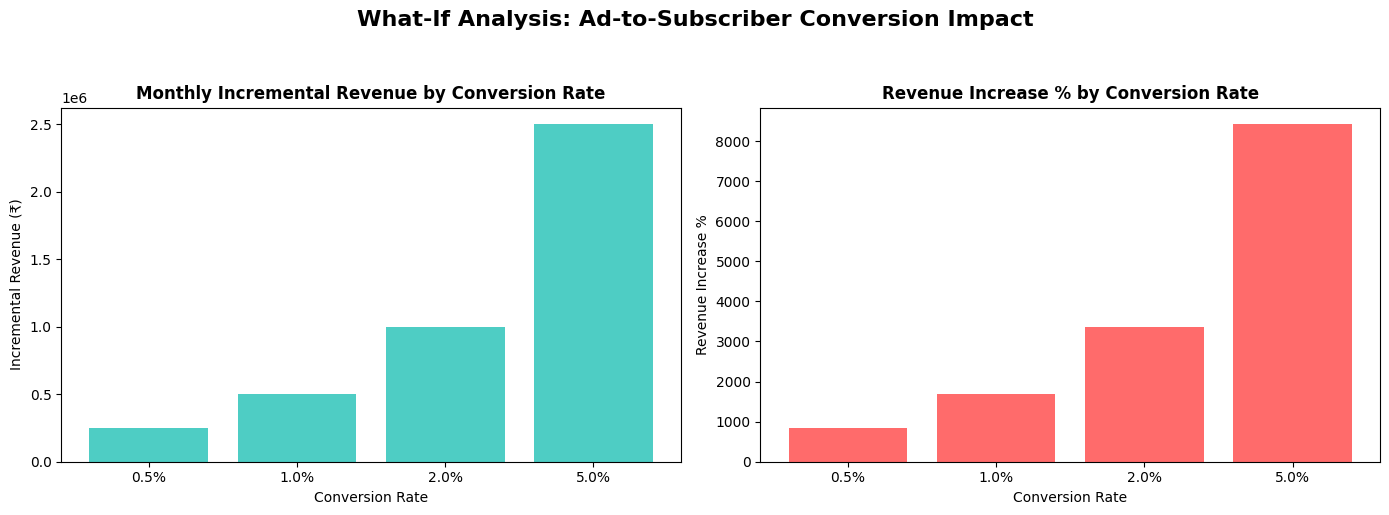


✅ Saved whatif_conversion_analysis.png

💡 INSIGHT: A 1% conversion rate would add ₹500,000.00 monthly revenue (1683.5% increase)


In [10]:
# Cell 10 — What-If: Convert Ad-Users to Subscribers (Cross-Sectional)
print("Running what-if analysis: Ad-user to subscriber conversion...\n")

# Assumptions (make these explicit and adjustable)
assumed_unique_ad_users = 1_000_000  # Replace with actual estimate if available
conversion_rates = [0.005, 0.01, 0.02, 0.05]  # 0.5%, 1%, 2%, 5%
avg_subscriber_monthly_revenue = 50.0  # ₹ per month per subscriber

results = []
for cr in conversion_rates:
    new_subs = assumed_unique_ad_users * cr
    monthly_increment = new_subs * avg_subscriber_monthly_revenue
    annual_increment = monthly_increment * 12
    pct_increase = (monthly_increment / total_revenue) * 100 if total_revenue > 0 else 0
    
    results.append({
        'conversion_rate_%': cr * 100,
        'new_subscribers': int(new_subs),
        'monthly_incremental_revenue': monthly_increment,
        'annual_incremental_revenue': annual_increment,
        'monthly_revenue_increase_%': pct_increase
    })

whatif_df = pd.DataFrame(results)
whatif_df.to_csv(OUTPUT_DIR/'whatif_conversion_results.csv', index=False)

print("WHAT-IF ANALYSIS: AD-USER TO SUBSCRIBER CONVERSION")
print("="*80)
print(f"Assumptions:")
print(f"  - Estimated unique ad-users:          {assumed_unique_ad_users:,}")
print(f"  - Avg subscriber monthly revenue:     ₹{avg_subscriber_monthly_revenue:.2f}")
print(f"  - Current total monthly revenue:      ₹{total_revenue:,.2f}")
print(f"\n✅ Exported whatif_conversion_results.csv\n")
display(whatif_df)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Monthly incremental revenue
axes[0].bar(whatif_df['conversion_rate_%'].astype(str) + '%', 
            whatif_df['monthly_incremental_revenue'], 
            color='#4ECDC4')
axes[0].set_title('Monthly Incremental Revenue by Conversion Rate', fontweight='bold')
axes[0].set_xlabel('Conversion Rate')
axes[0].set_ylabel('Incremental Revenue (₹)')
axes[0].tick_params(axis='x', rotation=0)

# Revenue increase percentage
axes[1].bar(whatif_df['conversion_rate_%'].astype(str) + '%', 
            whatif_df['monthly_revenue_increase_%'], 
            color='#FF6B6B')
axes[1].set_title('Revenue Increase % by Conversion Rate', fontweight='bold')
axes[1].set_xlabel('Conversion Rate')
axes[1].set_ylabel('Revenue Increase %')
axes[1].tick_params(axis='x', rotation=0)

plt.suptitle('What-If Analysis: Ad-to-Subscriber Conversion Impact', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR/'whatif_conversion_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Saved whatif_conversion_analysis.png")
print("\n💡 INSIGHT: A 1% conversion rate would add ₹{:,.2f} monthly revenue ({:.1f}% increase)".format(
    whatif_df[whatif_df['conversion_rate_%']==1.0]['monthly_incremental_revenue'].values[0],
    whatif_df[whatif_df['conversion_rate_%']==1.0]['monthly_revenue_increase_%'].values[0]
))

## Summary & Next Steps

**Completed Analyses**:
1. ✅ Cross-sectional KPI calculations
2. ✅ Top performers identification (artists, albums, tracks)
3. ✅ Anomaly detection (revenue outliers)
4. ✅ K-means clustering (hit/evergreen/niche classification)
5. ✅ Attribution analysis (platform comparison)
6. ✅ Elasticity modeling (log-log regression)
7. ✅ Fraud detection (IsolationForest)
8. ✅ Scenario-based revenue projections
9. ✅ What-if conversion simulations

**Exported Files** (in `outputs/advanced/`):
- `top_artists.csv`, `top_albums.csv`, `top_tracks.csv`
- `anomalies_cross_section.csv`
- `top_tracks_with_clusters.csv`
- `attribution_cross_section.csv`
- `elasticity_summary.txt`
- `fraud_flags.csv`
- `scenario_projections_3periods.csv`
- `whatif_conversion_results.csv`
- Various PNG visualizations

**Key Insights**:
- Clustering reveals distinct track types (hits vs niche vs evergreen)
- Platform attribution shows revenue efficiency differences
- Elasticity analysis quantifies sensitivity to volume changes
- Fraud detection identifies suspicious patterns
- Scenario projections provide growth roadmaps
- What-if simulations quantify conversion opportunities

**Recommendations**:
1. Focus promotion budget on identified "hit" clusters
2. Investigate fraud-flagged records for data quality issues
3. Use elasticity insights for pricing strategy
4. Implement conversion strategies based on what-if scenarios
5. Monitor cross-sectional KPIs regularly for trend detection